**Problem statement:** To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**The dataset** consists of 2239 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.


The data set contains the following diseases:

1. Actinic keratosis
2. Basal cell carcinoma
3. Dermatofibroma
4. Melanoma
5. Nevus
6. Pigmented benign keratosis
7. Seborrheic keratosis
8. Squamous cell carcinoma
9. Vascular lesion

### Importing Skin Cancer Data


In [19]:
!pip install tensorflow

In [20]:
!pip install keras

### Importing all the important libraries

In [21]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D, MaxPool2D

In [22]:
## mount the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Data Summary
This assignment uses a dataset of about 2239 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [23]:
# Defining the root path for train and test images 
root_path = '/content/gdrive/MyDrive/CNN_Skin_Cancer_dataset'
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')
#data_dir_train = pathlib.Path("C:\\PythonSetup\\jupyter_workspace\\CNN_assignment\\Train")
#data_dir_test = pathlib.Path("C:\\PythonSetup\\jupyter_workspace\\CNN_assignment\\Test")

In [24]:
# Print the number of tran and test images
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [25]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [26]:
## Load the train dataset, and use validation_split 0.2 while definiting
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "training",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
  )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [27]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split = 0.2,
    subset = "validation",
    seed = 123,
    image_size = (img_height, img_width),
    batch_size = batch_size
  )

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [28]:
#check the tensor shape
print(train_ds)
print(val_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [29]:
# print the class available in dataset (dataset should consist of 9 classes)

# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.

class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [30]:
# Define the test_ds from data_dir_test

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    image_size = (img_height, img_width),
    batch_size = batch_size
  )

Found 118 files belonging to 9 classes.


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

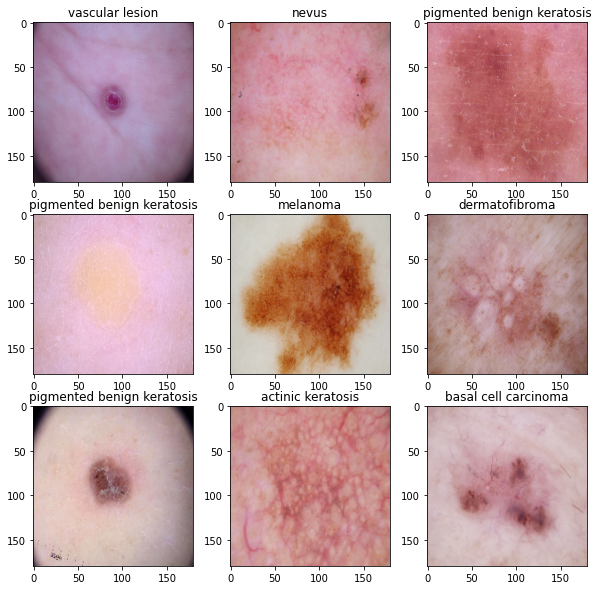

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    ax.set_title(class_names[labels[i]])
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [32]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [33]:

# Rescale the image
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

input_shape = (180,180,3)
num_classes = 9

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [34]:
### Todo, choose an appropirate optimiser and loss function
model.compile(
    optimizer ='adam', 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy']
)

In [35]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

### Train the model

In [36]:
epochs = 20 
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 40s 230ms/step - loss: 2.2109 - accuracy: 0.2048 - val_loss: 1.9942 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 9s 154ms/step - loss: 1.9183 - accuracy: 0.2930 - val_loss: 1.7834 - val_accuracy: 0.3356
Epoch 3/20
56/56 [==============================] - 9s 154ms/step - loss: 1.7522 - accuracy: 0.3605 - val_loss: 1.6068 - val_accuracy: 0.4116
Epoch 4/20
56/56 [==============================] - 9s 153ms/step - loss: 1.5974 - accuracy: 0.4219 - val_loss: 1.5358 - val_accuracy: 0.4407
Epoch 5/20
56/56 [==============================] - 9s 153ms/step - loss: 1.4938 - accuracy: 0.4732 - val_loss: 1.5812 - val_accuracy: 0.4631
Epoch 6/20
56/56 [==============================] - 9s 154ms/step - loss: 1.4030 - accuracy: 0.5011 - val_loss: 1.6442 - val_accuracy: 0.4340
Epoch 7/20
56/56 [==============================] - 9s 153ms/step - loss: 1.3616 - accuracy: 0.5195 - val_loss: 1.4587 - val_accuracy: 0.4989
Epoch

### Model overfit/under-fit (check the accuracy)?

In [37]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 1s 54ms/step - loss: 2.4131 - accuracy: 0.5324
Accuracy:  0.8950892686843872
Validation Accuracy:  0.5324384570121765
Loss:  0.31287577748298645
Validation Loss 2.4130966663360596


### Visualizing training results

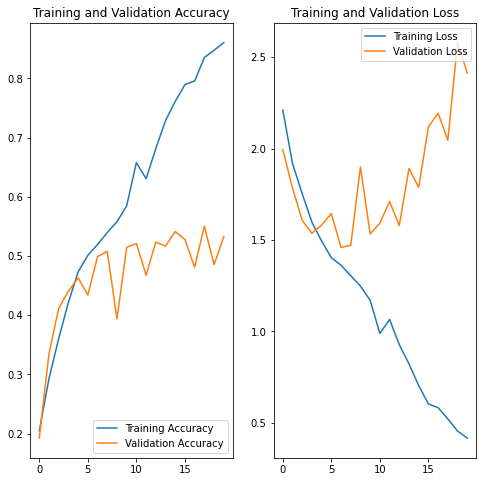

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### **Initial findings**

- In 20 epochs, we can observe the training accuracy is around 83.92%, where as validation accuracy is 54.36%. In terms of training and validation loss, we can observe training loss continuous decreases where as validation loss decreases upto 10 epoch and followed by a sharp increase in loss.

- **Model is overfitting,** as its calculated w.r.t. loss, and we can see the difference between loss in training and validation around 19-20th epoch; At the same we can notice training and validation accuracy




### Handle overfitting (Data augmentation)

- Data augmentation can be used in deep learning to handle overfitting. It can be used to generate more sample images by flipping or random rotation

In [39]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
from keras.preprocessing.image import ImageDataGenerator

data_aug = keras.Sequential([
       layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
       layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
       layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

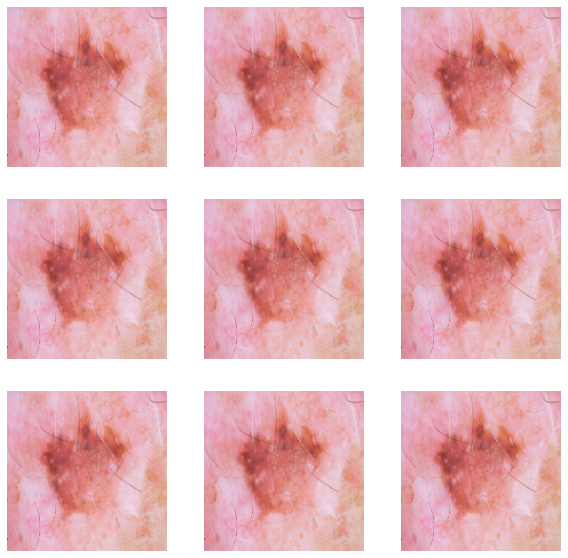

In [43]:
# Visualizing how my augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_aug(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Retraining the model by using Drop out layer to reduce overfitting

In [44]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
input_shape = (180,180,3)
num_classes = 9

model = Sequential([ data_aug,
   layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes))

### Compiling the model

In [45]:
## Your code goes here
model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy']
)

In [46]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 conv2d_9 (Conv2D)           (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 90, 90, 64)        18496     
                                                      

### Training the model

In [47]:
## Your code goes here
# Train model for more number of epochs to get better accuracy

epochs = 30
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/30
56/56 [==============================] - 11s 166ms/step - loss: 2.1617 - accuracy: 0.2227 - val_loss: 1.9120 - val_accuracy: 0.2774
Epoch 2/30
56/56 [==============================] - 9s 161ms/step - loss: 1.8082 - accuracy: 0.3432 - val_loss: 1.6494 - val_accuracy: 0.4407
Epoch 3/30
56/56 [==============================] - 9s 161ms/step - loss: 1.6391 - accuracy: 0.4113 - val_loss: 1.6553 - val_accuracy: 0.4206
Epoch 4/30
56/56 [==============================] - 9s 161ms/step - loss: 1.5334 - accuracy: 0.4515 - val_loss: 1.5304 - val_accuracy: 0.4922
Epoch 5/30
56/56 [==============================] - 9s 161ms/step - loss: 1.5522 - accuracy: 0.4403 - val_loss: 1.5656 - val_accuracy: 0.4787
Epoch 6/30
56/56 [==============================] - 9s 160ms/step - loss: 1.4596 - accuracy: 0.4838 - val_loss: 1.4915 - val_accuracy: 0.5034
Epoch 7/30
56/56 [==============================] - 9s 161ms/step - loss: 1.4138 - accuracy: 0.4833 - val_loss: 1.3986 - val_accuracy: 0.5391
Epoch

In [48]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 1s 54ms/step - loss: 1.4255 - accuracy: 0.5369
Accuracy:  0.5753348469734192
Validation Accuracy:  0.536912739276886
Loss:  1.1843560934066772
Validation Loss 1.4255458116531372


### Visualizing the results

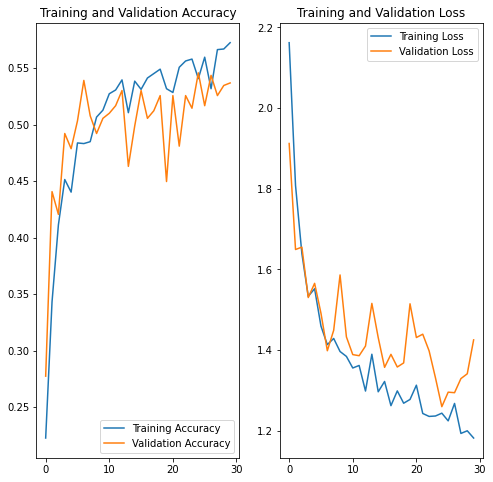

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### **Findings**

- With data augmentation strategy, we can see that training and validation accuracy fairly aligns and remain constant, where training and validation loss constantly decreases over period of time.

- Though model accuracy has gone down, but model is not overfitting and requires more hyper parameter tuning. one of the option could be to train for more number of epocs and see the accuracy.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

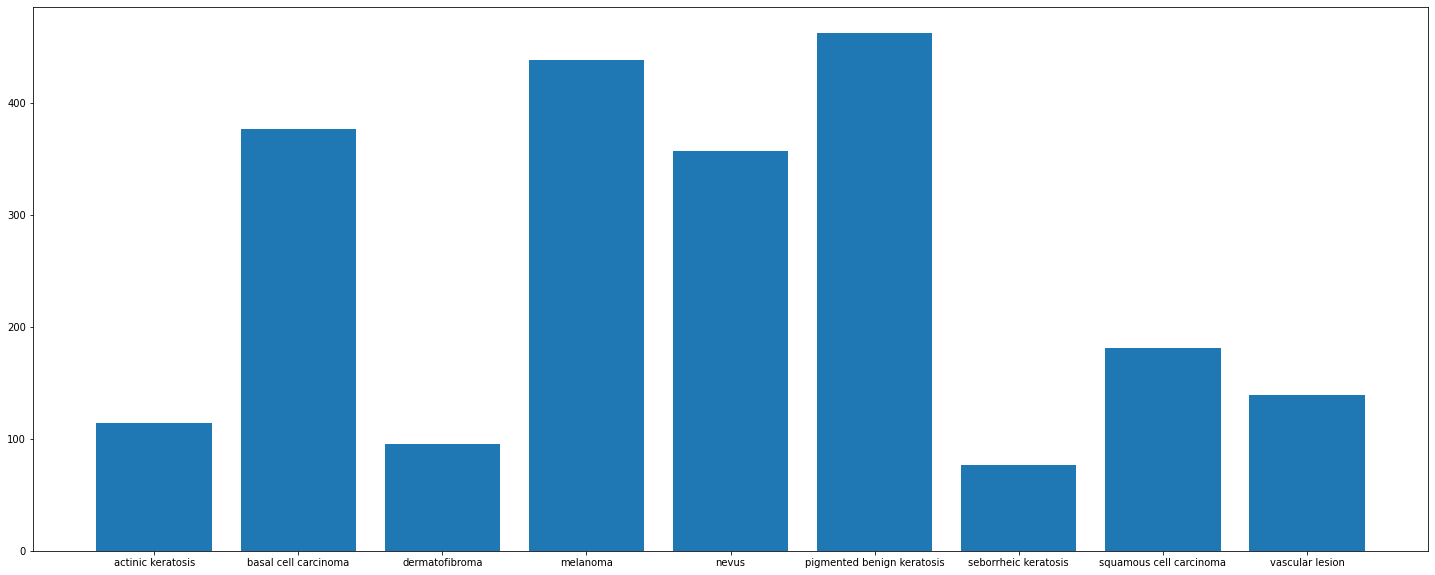

In [50]:
## Your code goes here.

count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?

- class has least number of samples is 'seborrheic keratosis'


#### - Which classes dominate the data in terms proportionate number of samples?
- Class "pigmented benign keratosis" dominate the data in presence


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [51]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [53]:
path_to_training_dataset = '/content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset+ "/" + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA749E73CD0>: 100%|██████████| 500/500 [00:26<00:00, 18.70 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7FA64C4411D0>: 100%|██████████| 500/500 [00:22<00:00, 22.22 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA64C492C50>: 100%|██████████| 500/500 [00:22<00:00, 21.83 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7FA749F04510>: 100%|██████████| 500/500 [01:40<00:00,  4.97 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7FA64C42D590>: 100%|██████████| 500/500 [01:35<00:00,  5.23 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA64C43DB90>: 100%|██████████| 500/500 [00:21<00:00, 22.87 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA749EC56D0>: 100%|██████████| 500/500 [00:51<00:00,  9.77 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA64C4B7850>: 100%|██████████| 500/500 [00:23<00:00, 21.61 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7FA64C4B7E10>: 100%|██████████| 500/500 [00:22<00:00, 22.70 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [54]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [55]:
from glob import glob

path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029041.jpg_0948cb7c-79d9-404d-9469-546346e92549.jpg',
 '/content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031922.jpg_c9e8ec78-6017-4c6d-b085-87e48d902fe6.jpg',
 '/content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027958.jpg_0a295eb0-943f-4df8-8f8a-0d64829ec197.jpg',
 '/content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0029827.jpg_3081ef0f-228f-497a-849a-6e425b1e92b1.jpg',
 '/content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028393.jpg_d9531755-0536-47ae-a044-d9aa0fb63211.jpg',
 '/content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0030463.jpg_ab5dccbe-4254-4b2e-a52b-dc7cbd7b8d2

In [56]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [57]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [58]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2) ## in upgrad content we can not see original_df
new_df = df2

In [59]:
new_df['Label'].value_counts()

actinic keratosis             500
seborrheic keratosis          500
melanoma                      500
squamous cell carcinoma       500
dermatofibroma                500
vascular lesion               500
pigmented benign keratosis    500
basal cell carcinoma          500
nevus                         500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [60]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [61]:
data_dir_train = '/content/gdrive/MyDrive/CNN_Skin_Cancer_dataset/Train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset ='training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size = (img_height, img_width),
  batch_size = batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [62]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [63]:
print(train_ds)
print(val_ds)

<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


#### **Todo:** Create your model (make sure to include normalization)

In [65]:
## your code goes here

# Rescale the image
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

input_shape = (180,180,3)
num_classes = 9

# Use the batch normalization and drop out to cehck the model

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(num_classes))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [66]:
## your code goes here
model.compile(optimizer='adam',
          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
          metrics=['accuracy']
)

In [67]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_13 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 45, 45, 64)       0         
 g2D)                                                 

#### **Todo:**  Train your model

In [68]:
epochs = 30 
history = model.fit(
  train_ds,
  validation_data = val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 47s 267ms/step - loss: 2.0001 - accuracy: 0.2535 - val_loss: 1.6527 - val_accuracy: 0.3415
Epoch 2/30
169/169 [==============================] - 44s 253ms/step - loss: 1.5347 - accuracy: 0.4132 - val_loss: 1.3500 - val_accuracy: 0.4759
Epoch 3/30
169/169 [==============================] - 44s 255ms/step - loss: 1.3573 - accuracy: 0.4917 - val_loss: 1.2246 - val_accuracy: 0.5419
Epoch 4/30
169/169 [==============================] - 44s 255ms/step - loss: 1.2336 - accuracy: 0.5438 - val_loss: 1.3327 - val_accuracy: 0.5278
Epoch 5/30
169/169 [==============================] - 45s 256ms/step - loss: 1.0639 - accuracy: 0.6150 - val_loss: 1.1168 - val_accuracy: 0.6125
Epoch 6/30
169/169 [==============================] - 45s 256ms/step - loss: 0.9000 - accuracy: 0.6695 - val_loss: 0.8709 - val_accuracy: 0.7038
Epoch 7/30
169/169 [==============================] - 44s 256ms/step - loss: 0.7727 - accuracy: 0.7213 - val_loss: 0.8629 - val_ac

### Model underfit/overfit (Check the accuracy)?

In [69]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

43/43 [==============================] - 8s 152ms/step - loss: 0.8417 - accuracy: 0.8070
Accuracy:  0.9642062187194824
Validation Accuracy:  0.8069784641265869
Loss:  0.08795829117298126
Validation Loss 0.8417079448699951


#### **Todo:**  Visualize the model results

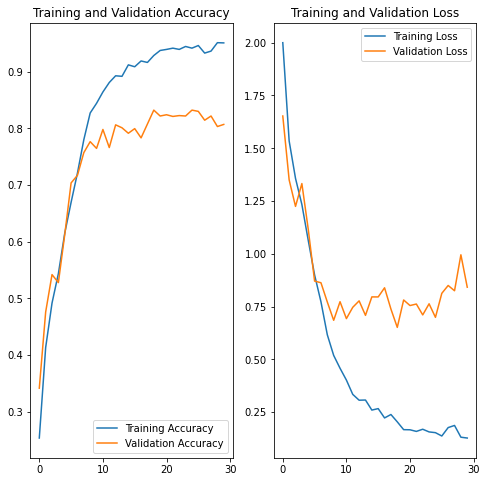

In [70]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**With class imbalance** and generating some sample images, we can see that training and validation accuracy has gone up. Training accuracy has increased upto > 90% and validation accuracy is around 81%. 

With more hyper parameter tunining, accuracy can be increased further.

### **Final summary**

- At first, model was overfitting with basic sample images where training accuracy was approx 90% and validation accuracy was 52%

- With basic tuning and help of ImageDataGenerator we were able to train the sample further and model seems to perform better where training and validation accuracy both were close to 57%.

- With class imbalance and generating more sample images, we could notice model improved further and training and validation accuracy both > 80%. 

**- With more hyper parameter tuning model can perform better.**